In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
# from run_mcts import Game, StabilityNode

# G = Game(StabilityNode, 'C')
# node = G.run_mcts().__next__()

In [3]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [4]:
config.experiment_id

'new_reward'

Text(0.5, 0, 'Time (hours)')

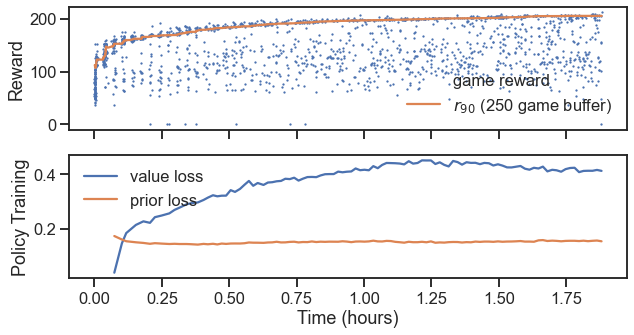

In [7]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time_hours, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

# axs[0].set_ylim([0, 150])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

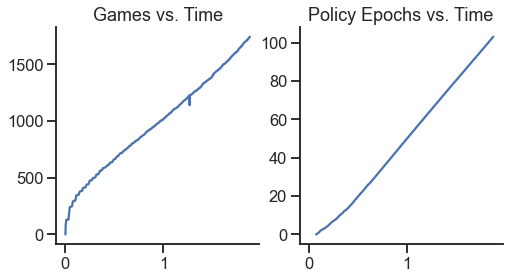

In [8]:
fig, axs = plt.subplots(figsize=(8,4), sharex=True, ncols=2)
axs[0].plot(df.time_hours, df.index)
axs[1].plot(log.time_hours, log.index)

axs[0].set_title('Games vs. Time')
axs[1].set_title('Policy Epochs vs. Time')

sns.despine()

In [9]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

,experiment_id
0,new_reward


In [10]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(687971, 10)

In [11]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
535520,CCCN(C(=C([NH])N)N(C)O)C(C)(C)C,2020-12-11 10:48:31.547492,214.19493,N,76.571434,0.247530,3,0.814302,-0.342940,75.695680
616378,CC(=O)C(=C(N)[N]O)N(C(C)C)C(C)C,2020-12-11 11:04:12.805959,213.69504,N,74.120300,0.208505,8,0.902202,-0.265700,68.132324
685010,CCC(=C(N)[N]C#N)N(C(C)C)C(C)C,2020-12-11 11:20:03.938187,213.40862,N,74.675650,0.225341,8,1.078731,-0.093053,69.694530
379151,C=C(N)NC(=C(C)[NH])N(CC)C(C)(C)C,2020-12-11 10:24:09.371025,213.31330,N,77.600710,0.285748,8,0.889911,-0.244979,75.270320
686472,C=CNC(=C(C)[NH])N(C(C)C)C(C)C,2020-12-11 11:20:34.867146,212.32796,N,73.098100,0.213146,7,0.884753,-0.384387,75.600580
535515,CCCCN(C(NO)=C([NH])N)C(C)(C)C,2020-12-11 10:48:31.488737,212.09105,N,74.175735,0.241694,4,0.886547,-0.231017,74.436830
378553,C=C(N)NC(=C(C)[NH])N(C(C)C)C(C)C,2020-12-11 10:24:04.559341,212.05283,N,75.518410,0.258783,8,1.088247,-0.146128,76.216545
533769,CCCN(C(NO)=C([NH])O)C(C)(C)C,2020-12-11 10:48:13.311417,211.35179,N,74.182760,0.256619,3,0.963927,-0.352362,71.299480
541850,C=C(N)NC(=C(C)[O])N(C(C)C)C(C)C,2020-12-11 10:49:29.143773,210.46342,N,74.919610,0.289124,8,1.005154,-0.227957,63.743565
534798,CC(C)N(CCCCO)C(NO)=C([NH])N,2020-12-11 10:48:24.002505,210.16351,N,73.101460,0.258759,3,1.018460,-0.143240,74.586620


In [12]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [13]:
from rdkit import Chem

INFO:rdkit:Enabling RDKit 2020.03.4 jupyter extensions


In [22]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [23]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
213330,CC1(C)CCC(C)(C)N1[O],2020-12-11 10:01:52.728404,114.30535,N,63.39211,0.481735,8,4.723985,2.725151,66.86215


In [27]:
stable_df[stable_df.smiles == 'CC1(C)CCC(C)(C)N1[O]']

,File,Name,Smiles,mol-block,atom-idx-log,atom-idx-smi,atom-sym,atom-sym-idx,spin-density,bur-vol,fractional_spin,smiles
40,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,1,0,C,C1,0.004015,51.132700,0.003712,CC1(C)CCC(C)(C)N1[O]
41,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,2,1,C,C2,0.001549,51.223437,0.001432,CC1(C)CCC(C)(C)N1[O]
42,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,3,2,C,C3,-0.019170,58.368319,0.017725,CC1(C)CCC(C)(C)N1[O]
43,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,4,3,C,C4,-0.017005,58.325982,0.015723,CC1(C)CCC(C)(C)N1[O]
44,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,5,4,H,H5,-0.003240,NaN,NaN,CC1(C)CCC(C)(C)N1[O]
45,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,6,5,H,H6,-0.002580,NaN,NaN,CC1(C)CCC(C)(C)N1[O]
46,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,7,6,H,H7,-0.000048,NaN,NaN,CC1(C)CCC(C)(C)N1[O]
47,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,8,7,N,N8,0.535764,64.129450,0.495385,CC1(C)CCC(C)(C)N1[O]
48,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,9,8,O,O9,0.445485,43.687276,0.411910,CC1(C)CCC(C)(C)N1[O]
49,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,10,9,C,C10,0.023386,42.756305,0.021623,CC1(C)CCC(C)(C)N1[O]


In [ ]:
stable_max_spin

In [ ]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [ ]:
pass_gng.shape

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
win

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())